## Develop an Embedding + CNN Model for Sentiment Analysis.

#### 1. Movie Review Dataset

Remember the movie review dataset? That's the one we're going to use.

In [2]:
!ls Data/txt_sentoken

neg  pos


#### 2. Data Preparation

In [3]:
# Import the functions  we had created.
from numpy import array
from save_processed import *
from text_prep import *

Using TensorFlow backend.


In [4]:
%whos

Variable            Type                Data/Info
-------------------------------------------------
Tokenizer           type                <class 'keras_preprocessing.text.Tokenizer'>
add_doc_to_vocab    function            <function add_doc_to_vocab at 0x7f6c01a32a60>
clean_doc           function            <function clean_doc at 0x7f6c75172488>
create_tokenizer    function            <function create_tokenizer at 0x7f6c01a32c80>
doc_to_line         function            <function doc_to_line at 0x7f6c75153d90>
load_doc            function            <function load_doc at 0x7f6c75153f28>
os                  module              <module 'os' from '/usr/lib/python3.7/os.py'>
process_docs        function            <function process_docs at 0x7f6c01a32ae8>
process_docs_full   function            <function process_docs_full at 0x7f6c01a32d08>
re                  module              <module 're' from '/usr/lib/python3.7/re.py'>
remove_min          function            <function remove_min at 

##### 2.1. Split into train and test sets

We'll split each class into 900 for training and 100 for testing. In total we should 1800 in both classes for training and 200 in both classes for testing.

##### 2.2. Load and clean data to remove punctuations and numbers

To Do:
    * Split tokens by white space.
    * Remove all punctuation from words.
    * Remove all words that are not purely comprised of alphabetical characters.
    * Remove all words that are known stop words.
    * Remove all words that have a length <= 1 character.

We'll use the following functions:
    * load_doc: Loads our reviews to memory.
    * clean_doc: takes our loaded document and cleans it up based on the to do above.

In [5]:
# Testing our functions still work
file = 'Data/txt_sentoken/pos/cv000_29590.txt'
text = load_doc(file)
tokens = clean_doc(text)
print(tokens)

['films', 'adapted', 'comic', 'books', 'plenty', 'success', 'whether', 'theyre', 'superheroes', 'batman', 'superman', 'spawn', 'geared', 'toward', 'kids', 'casper', 'arthouse', 'crowd', 'ghost', 'world', 'theres', 'never', 'really', 'comic', 'book', 'like', 'hell', 'starters', 'created', 'alan', 'moore', 'eddie', 'campbell', 'brought', 'medium', 'whole', 'new', 'level', 'mid', 'series', 'called', 'watchmen', 'say', 'moore', 'campbell', 'thoroughly', 'researched', 'subject', 'jack', 'ripper', 'would', 'like', 'saying', 'michael', 'jackson', 'starting', 'look', 'little', 'odd', 'book', 'graphic', 'novel', 'pages', 'long', 'includes', 'nearly', 'consist', 'nothing', 'footnotes', 'words', 'dont', 'dismiss', 'film', 'source', 'get', 'past', 'whole', 'comic', 'book', 'thing', 'might', 'find', 'another', 'stumbling', 'block', 'hells', 'directors', 'albert', 'allen', 'hughes', 'getting', 'hughes', 'brothers', 'direct', 'seems', 'almost', 'ludicrous', 'casting', 'carrot', 'top', 'well', 'anythi

Looks like they work just fine!!

##### 2.3. Define a vocabulary of preferred words

It's important to define a vocab of known words when using a text model. The more words, the larger the representation of documents. therefore we want to constrain our words to only those we believe to be predictive.

We can develop a vocab as a Counter, which is a dictionary mapping of words and their counts that allows us to easily update and query. Each document can be added to the counter and we can step over all the reviews in time.

We'll use the following functions:
    * add_doc_to_vocab: This adds successive documents and their words to a Counter class to create a vocabulary.
    * process_docs: Steps over all the selected documents we want for our train set only, and extracts their words.
    * remove_min: removes tokens less than a particular amount in the vocab.
    * save_list: Saves a created vocabulary to a text file to be loaded for other tasks.

In [6]:
# Import Counter module
from collections import Counter
# Define Vocab
vocab = Counter()
# Add all docs to vocab
process_docs('Data/txt_sentoken/pos', vocab)
process_docs('Data/txt_sentoken/neg', vocab)
# print the size of the vocab
print(len(vocab))

44276


In [10]:
# Keep tokens with minimum occurence
vocab_new = remove_min(2, vocab)
print(len(vocab_new))

25767


In [11]:
# Save new vocab to text file in directory
save_list(vocab_new, 'Data/new_vocab_25767.txt')

Done saving vocabulary to Data/new_vocab_25767.txt ...


#### 3. Train CNN with Embedding Layer

Now we will learn a word embedding while training a CNN on the classification problem.

First we need to load our vocabulary file that we saved 'new_vocab_25767.txt' and use this for what we need.

Then we'll load on all our training reviews.

We call the process_docs_full function on our negative and positive reviews and combine into a single train or test dataset.

We also define the class labels for the dataset using a new function.

Next, we'll encode each document as a sequence of integers. Each integer maps to a single token that has a specific real valued vector representation within the embedding. These vectors are random at the begining of training, but during training become meaningful to the network.

Finally, after mapping the words to integers, we need to ensure that all documents have the same length. We'll thus using padding to get them all to the same size suing the length of the longest review in the train set. We will create a function for this.

To wrap it all up, we define a vocab size and create our model, using an embedding layer for our input and CNN layer(s).

The modules we'll use in this section are:
    * process_docs_full: Loads multiple files to memory while allowing to split between train and test.
        * doc_to_line: converts all loaded text to line after cleaning. # This function is in the process_docs_full function.
    * create_tokenizer: This creates an encoding of the cleaned documents.

In [12]:
# Load the vocab
vocab_file = 'Data/new_vocab_25767.txt'
loaded_vocab = load_doc(vocab_file)
loaded_vocab = set(loaded_vocab.split())

In [15]:
# Load, clean and combine a dataset
def load_clean_dataset(vocab, is_train):
    """
    params:
    vocab: train vocabulary
    is_train: switch to select training and testing sets. Set to True for train, False for test.
    
    return:
    docs: a combined documents dataset
    labels: all labels in the set"""
    # load documents
    neg = process_docs_full('Data/txt_sentoken/neg', vocab, is_train)
    pos = process_docs_full('Data/txt_sentoken/pos', vocab, is_train)
    docs = neg + pos
    # prepare labels
    labels = array([0 for _ in range(len(neg))] + [1 for _ in range(len(pos))])
    return docs, labels

# Integer encode and pad documents
def encode_docs(tokenizer, max_length, docs):
    """
    params:
    tokenizer: a tokenizer class created from the function create_tokenizer
    max_length: a maximum length all documents must have, gotten from the size of the largest document
    docs: a combined review set of positive and negative.
    
    returns:
    padded: an integer encoded, padded sequence of documents.
    """
    # integer encode 
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

In [16]:
# Load training data
train_docs, y_train = load_clean_dataset(loaded_vocab, True)
# Create the tokenizer
tokenizer = create_tokenizer(train_docs)
# Define vocab size 
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %s'% vocab_size)

Vocabulary size: 25768


In [17]:
# Get the maximum sequence length
max_length = max([len(s.split()) for s in train_docs])
print('Maximum length: %d'% max_length)

Maximum length: 1317


In [25]:
# import modules
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Flatten, Embedding
from keras.models import Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils import plot_model
# Import keras load_model
from keras.models import load_model

In [22]:
# Encode data
X_train = encode_docs(tokenizer, max_length, train_docs)
X_train.shape, y_train.shape

((1800, 1317), (1800,))

In [26]:
# Define model
def embed_cnn_model(vocab_size, max_length):
    visible = Input(shape=(max_length,))
    embed1 = Embedding(vocab_size, 100)(visible)
    conv1 = Conv1D(filters=32, kernel_size=8, activation='relu')(embed1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    flat1 = Flatten()(pool1)
    fc1 = Dense(10, activation='relu')(flat1)
    output = Dense(1, activation='sigmoid')(fc1)
    model = Model(inputs = visible, outputs = output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model    

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1317)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1317, 100)         2576800   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1310, 32)          25632     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 655, 32)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 20960)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                209610    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11  

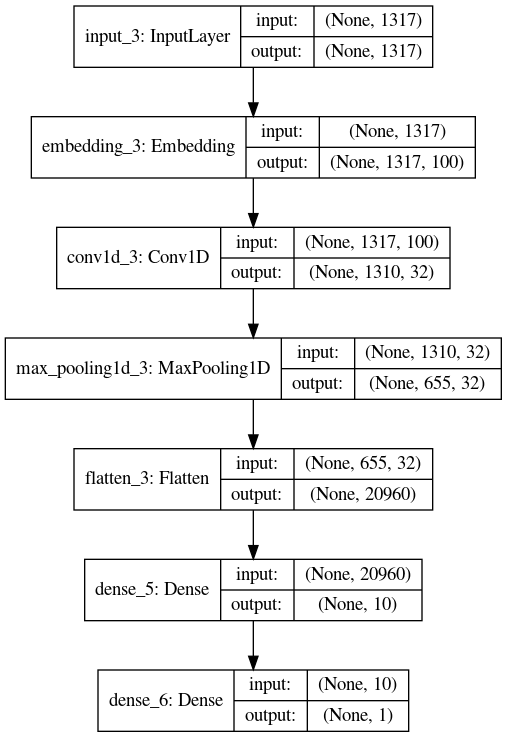

In [29]:
# Call model
model = embed_cnn_model(vocab_size, max_length)
# View the summary
model.summary()
# Plot the model
plot_model(model, to_file='Model_Imgaes/embed+cnn_model.png', show_shapes=True)

In [30]:
# Fit network
model.fit(X_train, y_train, epochs=10, verbose=2)
# save the model
model.save('Models/embed+cnn_model.h5')

/home/michael/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
 - 9s - loss: 0.6944 - accuracy: 0.4906
Epoch 2/10
 - 9s - loss: 0.6775 - accuracy: 0.5561
Epoch 3/10
 - 10s - loss: 0.4852 - accuracy: 0.8411
Epoch 4/10
 - 13s - loss: 0.3390 - accuracy: 0.9733
Epoch 5/10
 - 11s - loss: 0.3078 - accuracy: 0.9928
Epoch 6/10
 - 12s - loss: 0.2900 - accuracy: 0.9928
Epoch 7/10
 - 10s - loss: 0.2749 - accuracy: 0.9939
Epoch 8/10
 - 9s - loss: 0.2626 - accuracy: 0.9939
Epoch 9/10
 - 9s - loss: 0.2511 - accuracy: 0.9944
Epoch 10/10
 - 9s - loss: 0.2407 - accuracy: 0.9944


#### 4. Evaluate Model

Now we have our model run and saved, we can load our test set and a new unseen review case to evaluate the model.

First we'll define a function to help us predict a new review case.

In [34]:
# load test sets
test_docs, y_test = load_clean_dataset(loaded_vocab, False)
# Encode data
X_test = encode_docs(tokenizer, max_length, test_docs)
# load the model
model1 = load_model('Models/embed+cnn_model.h5')
# Evaluate the model on the train
_, acc = model1.evaluate(X_train, y_train, verbose=0)
print('Train Accuracy: %.2f%%' %(acc*100))
# Evaluate the model on the test
_, acc = model1.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.2f%%' %(acc*100))

/home/michael/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train Accuracy: 99.44%
Test Accuracy: 87.50%


In [31]:
# Clean a new document
def cleaned_doc(doc, vocab):
    """
    vocabulary should be vocabulary that has been worked on or loaded newly"""
    # split into tokens
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]'% re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out tokens not in vocab
    tokens = [w for w in tokens if w in vocab]
    tokens = ' '.join(tokens)
    return tokens


# Function to classify a new review
def predict_sentiment(review, vocab, tokenizer, max_length, model):
    """
    params:
    review: a new test case to predict
    vocab: a train or document vocabulary. Remember this should be the vocab with the small occurences removed.
    tokenizer: a text tokenizer to encode text
    max_length: the max_length to pad our review to
    model: a trained model
    
    return:
    sentiment: POSITIVE or NEGATIVE
    """
    # Clean review
    line = cleaned_doc(review, vocab)
    # encode and pad review
    padded = encode_docs(tokenizer, max_length, [line])
    # predict sentiment
    yhat = model.predict(padded, verbose=0)
    # Retrieve the predicted percentage and label
    percent_pos = yhat[0,0]
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

In [36]:
# Create test cases
text1 = 'Everyone will enjoy this movie, I really love it, strongly recommend!'
percent, sentiment = predict_sentiment(text1, loaded_vocab, tokenizer, max_length, model1)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text1, sentiment, percent*100))

Review: [Everyone will enjoy this movie, I really love it, strongly recommend!]
Sentiment: NEGATIVE (60.605%)


In [38]:
# Create test cases
text2 = 'This is a totally bad movie. Do not watch it, it sucks.'
percent, sentiment = predict_sentiment(text2, loaded_vocab, tokenizer, max_length, model1)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text2, sentiment, percent*100))

Review: [This is a totally bad movie. Do not watch it, it sucks.]
Sentiment: NEGATIVE (63.151%)


### Extensions

Here are some ideas to extend the work done above:
    1. Data cleaning: Explore better cleaning options, perhaps leaving some punctuations in tact or normalizing contractions.
    2. Truncated sequences: Padding all sequences to the length of the longest sequence might be extreme if the longest sequence is very different to all other reviews. 
        Study the distribution of review lengths and truncate reviews to a mean length.
    3. Truncated vocabulary: We removed infrequently occuring words, but still had a large vocabulary of more than 25,000 words. Explore further reducing the size of the vocabulary and the effect on the model skill.
    4. Filters and kernel size: The number of filters and kernel size are important to model skill and were not tuned. Explore tuning these two parameters.
    5. Epochs and Batch Size: The model appears to fit the training dataset quickly. Explore alternate configurations of the number of training epochs and batch size and use the test dataset as a validation set to pick a better stopping point for training the model.
    6. Deeper network: Explore whether a deeper network results in better skill, either in terms of CNN layers, MLP layers and both.
    7. Pre-train an Embedding: Explore pre-training a Word2Vec word embedding in the model and the impact on model skill with and without further fine tuning during training.
    8. Use GloVe Embedding: Explore loading the pretrained GloVe embedding and the impact on model skill with and without further fine tuning during training.
    9. Longer Test Reviews: Explore whether the skill of model predictions is dependent on the length of the movie reviews as suspected in the final section on evaluating the model.
    10. Train Final Model: Train a final model on all available data and use it to make predictions on real ad hoc movie reviews from the internet.